In [1]:
!pip install git+https://github.com/kornia/kornia

  Cloning https://github.com/kornia/kornia to /tmp/pip-req-build-jnyaor5i
  Running command git clone -q https://github.com/kornia/kornia /tmp/pip-req-build-jnyaor5i
  Created wheel for kornia: filename=kornia-0.1.2+439b6c6-py2.py3-none-any.whl size=129571 sha256=4595410cb591863143fff15e2424bdebe904d980cb81154e6c013400fac35f8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-p3_gys7_/wheels/5f/8b/92/375714dc479253f78ed777dd105d79f9693448dcfef85c8163
Successfully built kornia


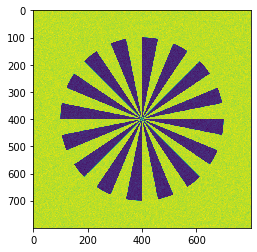

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import kornia
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from kornia.feature import *
from kornia.geometry import *

from kornia import tensor_to_image as tti

def visualize_LAF(img, LAF, img_idx = 0):
    x, y = kornia.feature.laf.get_laf_pts_to_draw(LAF, img_idx)
    plt.figure()
    plt.imshow(kornia.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'r')
    plt.show()
    return

img = Image.open('data/matching/siemens.png')
# Image with synthetic pattern from SFOP paper: 
# http://www.ipb.uni-bonn.de/data-software/sfop-keypoint-detector/

timg = kornia.utils.image_to_tensor(np.array(img), keepdim=False).float() / 255. / 255. 
#Yes, it is not a typo. 
#This specific image somehow has [0, 255**2] range

plt.imshow(kornia.utils.tensor_to_image(timg[0]))

Kornia has a module ScaleSpaceDetector for local feature extraction.
It consists of several modules, each one is tunable and differentiable:

1. Scale pyramid
2. Responce (aka "cornerness")
3. Soft non-maxima-suppression
4. Affine shape detector
5. Orientation detector

The output is two tensors: with responces and with local affine frames (LAFs). You can feed LAFs to extract_patches function to then describe the corresponding patches. Let's go over all this modules step by step

ScalePyramid create spyramid of blurred and downsamples images

In [2]:
SP = ScalePyramid(3, 1.6, 10)

pyr, sigmas, scales = SP (timg)
print (len(pyr), pyr[0].shape)

7 torch.Size([1, 1, 6, 800, 800])


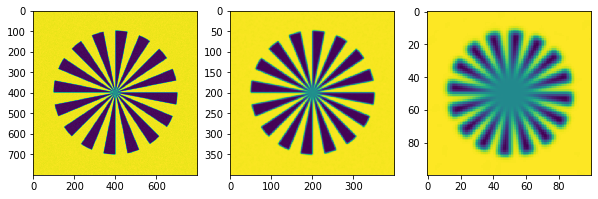

In [4]:
fig, axes = plt.subplots(1,3, figsize=(10,6))
ax = axes[0]
ax.imshow(tti(pyr[0][0,0,0]))
ax = axes[1]
ax.imshow(tti(pyr[1][0,0,0]))
ax = axes[2]
ax.imshow(tti(pyr[3][0,0,0]))
current_level = pyr[1]

Response function calculate some feature score - "cornerness", "blobness", etc.
Kornia has CornerHarris, CornerGFTT and BlobHessian modules

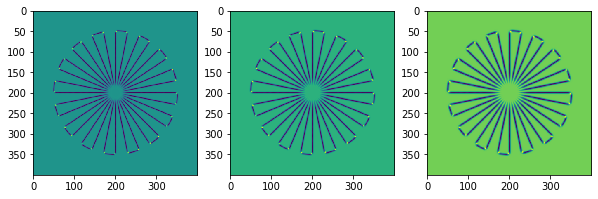

In [12]:
resp = kornia.feature.responses.CornerHarris(0.05)

fig, axes = plt.subplots(1,3, figsize=(10,6))

cornerness = resp(current_level[0])
for i in range(3):
    ax = axes[i]
    ax.imshow(tti(cornerness[0,i]))


The next component is detector of the maximum of the local responce: ConvQuadInterp3d(), 
which does quadratic interpolation of the location,
or ConvSoftArgmax3d, which does softargmax estimation of the location.

In [13]:
nms1 = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), # nms windows size (scale, height, width)
                                       stride=(1,1,1), # stride (scale, height, width)
                                       padding=(1, 1, 1),
                                       temperature=0.1) # nms windows size (scale, height, width)

And the last one is ScaleSpaceDetector, which combines everything together and output the local features

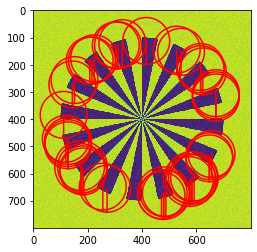

In [14]:
#Lets detect Harris corners
n_feats = 40
mr_size = 6.0 
nms1 = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), # nms windows size (scale, height, width)
                                       stride=(1,1,1), # stride (scale, height, width)
                                       padding=(1, 1, 1),
                                       temperature=0.1) # nms windows size (scale, height, width)

harris_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms1,
                                    mr_size=mr_size)
lafs, resps = harris_local_detector(timg)
visualize_LAF(timg, lafs)

You can see that there are lots of paired detections. 
That is because softargmax output (almost) same locations for nearby points. 
One can fix this by adding a "bonus" to true maxima locations

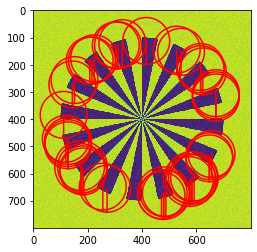

In [15]:
#n_feats = 40
mr_size = 6.0 
nms1 = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), # nms windows size (scale, height, width)
                                       stride=(1,1,1), # stride (scale, height, width)
                                       padding=(1, 1, 1),
                                       temperature=0.1,
                                       strict_maxima_bonus=100.) # nms windows size (scale, height, width)

harris_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms1,
                                    mr_size=mr_size)
lafs, resps = harris_local_detector(timg)
visualize_LAF(timg, lafs)

Or use by using quadratic interpolation instead

In [22]:
help(kornia.geometry.ConvQuadInterp3d())

Help on ConvQuadInterp3d in module kornia.geometry.subpix.spatial_soft_argmax object:

class ConvQuadInterp3d(torch.nn.modules.module.Module)
 |  ConvQuadInterp3d(strict_maxima_bonus: float = 10.0, eps: float = 1e-07) -> None
 |  
 |  Module that calculates soft argmax 3d per window
 |  See :func:`~kornia.geometry.subpix.conv_quad_interp3d` for details.
 |  
 |  Method resolution order:
 |      ConvQuadInterp3d
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, strict_maxima_bonus: float = 10.0, eps: float = 1e-07) -> None
 |      Initializes internal Module state, shared by both nn.Module and ScriptModule.
 |  
 |  __repr__(self) -> str
 |      Return repr(self).
 |  
 |  forward(self, x: torch.Tensor)
 |      Defines the computation performed at every call.
 |      
 |      Should be overridden by all subclasses.
 |      
 |      .. note::
 |          Although the recipe for forward pass needs to be defined within
 | 

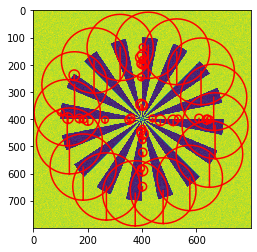

In [29]:
#Lets detect Harris corners w/o duplicates
n_feats = 50
mr_size = 6.0 
nms = kornia.geometry.ConvQuadInterp3d(10, 2e-4)

harris_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms,
                                    mr_size=mr_size)

lafs, resps = harris_local_detector(timg)
visualize_LAF(timg,lafs)


Now we are much better. But what about symmetrical responce functions, like Hessian or Difference of Gaussians,
where both minima and maxima are equally good points?
In that case we could pass **minima_are_also_good** flag to the  ScaleSpaceDetector.

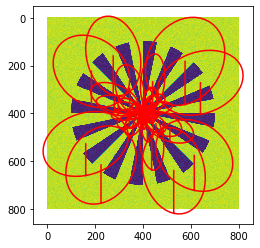

In [31]:
# What about Harris-Affine features?
harris_affine_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=kornia.feature.CornerHarris(0.05),
                                    nms_module=nms,
                                    mr_size=mr_size,
                                    aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),
                                    minima_are_also_good=False)
lafs, resps = harris_affine_local_detector(timg)
visualize_LAF(timg,lafs)

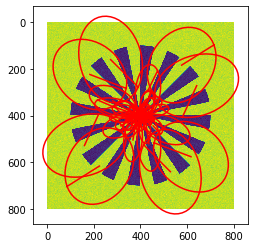

In [32]:
# Now lets also detect feature orientation
harris_affine_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=kornia.feature.CornerHarris(0.05),
                                    nms_module=nms,
                                    mr_size=mr_size,
                                    aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),
                                    ori_module=kornia.feature.LAFOrienter(patch_size=19))

lafs, resps = harris_affine_local_detector(timg)
visualize_LAF(timg,lafs)

In [33]:
#Lets describe patches with SIFT descriptor
descriptor = kornia.SIFTDescriptor(32)

patches =  kornia.feature.extract_patches_from_pyramid(timg, lafs)
B, N, CH, H, W = patches.size()
# Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
# So we need to reshape a bit :) 
descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
print (descs.shape)
print (descs[0, 0])

torch.Size([1, 50, 128])
tensor([1.9561e-02, 9.3442e-03, 8.4530e-03, 3.0934e-03, 1.9743e-01, 1.3250e-01,
        5.6045e-02, 9.8801e-03, 1.9829e-01, 1.9829e-01, 5.1721e-02, 1.0856e-01,
        1.6818e-01, 1.9829e-01, 6.0795e-02, 2.4890e-02, 5.4012e-03, 6.6747e-03,
        5.2353e-03, 1.3258e-02, 4.2114e-03, 6.4484e-02, 2.0408e-02, 6.1776e-03,
        8.0690e-03, 1.6117e-01, 9.7051e-02, 1.1491e-01, 3.1668e-02, 1.5716e-01,
        1.9829e-01, 8.6925e-02, 7.2595e-03, 7.4113e-03, 6.3001e-03, 7.4723e-03,
        2.6570e-03, 3.6178e-03, 7.3476e-03, 9.3490e-03, 3.4381e-02, 1.0000e-05,
        1.5193e-02, 1.2682e-02, 2.6779e-02, 2.3610e-02, 4.6784e-02, 2.4468e-02,
        8.0844e-03, 9.1491e-03, 1.0276e-02, 2.3237e-03, 1.1213e-02, 1.1704e-02,
        1.0727e-02, 1.1592e-02, 8.1392e-02, 2.3917e-02, 4.9292e-03, 7.6980e-03,
        1.7122e-01, 2.7440e-02, 1.0892e-02, 2.1009e-03, 7.1120e-03, 1.0108e-02,
        7.6888e-03, 5.1856e-03, 1.3635e-01, 1.4495e-01, 2.0291e-02, 8.5300e-03,
        1.7331e